## RBF implementation for simple structural deformation for a single step.

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as pl

In [2]:
# import the fem libraries
from dolfin import *
# import numpy as np
# define the boundary
class boundary(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] < 0.4 and on_boundary
# define a unit cube
mesh = UnitCubeMesh(5,5,5)
# define function space
V = FunctionSpace(mesh, "CG", 1)
# project an approximate Expression of function space using FEM 
v = project(Expression("x[1]*x[2]", degree=2),V)
mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary().mark(mf, 1)
#define the degree of freedom map
v2d = vertex_to_dof_map(V)
dofs = []
for facet in facets(mesh):
    if mf[facet.index()] == 1:
        vertices = facet.entities(0)
        for vertex in vertices:
            dofs.append(v2d[vertex])
# extract the displacements on the boundaries and the required faces
unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
boundary_coords = V.tabulate_dof_coordinates()[unique_dofs]
N=len(boundary_coords[:,1])
g=np.zeros((N,3))
for i, dof in enumerate(unique_dofs):
    g[i,0]=v.vector()[dof]
#     print(boundary_coords[i], v.vector()[dof])


In [3]:
g.shape

(56, 3)

In [4]:
# extract the mesh coordinates 
coor=V.tabulate_dof_coordinates()
num_coor=len(coor[:,1])
# define the dontrol points as the boundary point where the displacements are known 
ctr_pts=np.array(boundary_coords)

In [5]:
# nx, ny, nz = (10, 10, 10)
# mesh = np.zeros((nx * ny * nz, 3))

# xv = np.linspace(0, 1, nx)
# yv = np.linspace(0, 1, ny)
# zv = np.linspace(0, 1, nz)
# z_1, y_1, x_1 = np.meshgrid(zv, yv, xv)

# # mesh = np.array([x.ravel(), y.ravel(), z.ravel()])
# # mesh = mesh.T

In [6]:
# num_coor=len(x_1.flatten())
# coor=np.zeros((num_coor,3))
# coor[:,0]=x_1.flatten()
# coor[:,1]=y_1.flatten()
# coor[:,2]=z_1.flatten()

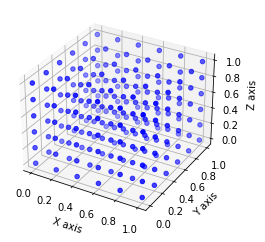

In [7]:
# 3d plotting in matplotlib  
fig = pl.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coor[:, 0], coor[:, 1], coor[:, 2], c='blue', marker='o')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
pl.show()

In [8]:
# N=len(ctr_pts)
# g=np.zeros((N,3))
# for i in range(N):
#     g[i,0]=

In [9]:
# the p vector essentially containig the normalised parametric representation of control points
P=np.zeros((N,4))
for i in range(N):
    for j in range(4):
        if (j==0): P[i,j]=1
        else: P[i,j]=ctr_pts[i,j-1]
# known displacements


In [10]:
P.shape

(56, 4)

In [11]:
# define the euclidean distances
def rd(c1, c2):
    return np.sqrt((c1[0]-c2[0])**2+(c1[1]-c2[1])**2+(c1[2]-c2[2])**2)
#rbf as global support spline type
def rbf(r):
    return np.exp(-r**2)

In [12]:
# define lhs RBF kernel 
def M(coor,ctr_pts):
    M_m=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M_m[i,j]=rbf(rd(ctr_pts[i],ctr_pts[j]))
    return M_m
# lhs of the rbf equation to be solved
def lhs_(P,M_m):
    lhs=np.zeros((N+4,N+4))
    P_t=np.transpose(P)
    for i in range(N+4):
        for j in range(N+4):
            if (i<N and j<N): lhs[i,j]=M_m[i,j]
            elif (i<N and j>(N-1)): lhs[i, j]=P[i,j-N]
            elif (i>(N-1) and j<N):lhs[i,j]= P_t[i-N,j]
    return lhs
# solve the matrices
def sol_yb(lhs, g):
    rhs=np.zeros((N+4,3))
    for i in range(N):
        for j in range(3):    
            rhs[i,j]=g[i,j]
    
    inv_lhs=np.linalg.inv(lhs)
    yb= inv_lhs @ rhs
    gmma=np.zeros((N,3))
    beta=np.zeros((4,3))
    for i in range(N+4):
        if (i<N): gmma[i,:]=yb[i,:]
        else : beta[i-N,:]=yb[i,:]
    return (gmma, beta)
                


In [13]:
# calculate the displacement in anyother normal mesh point
def s_x(ctr_pts, coor, beta, gmma):
    s_x=np.zeros(3)
    for i in range(3):
        for j in range(N):
            s_x[i]=s_x[i]+gmma[j,i]*rbf(rd(coor, ctr_pts[j]))
        s_x[i]=s_x[i]+beta[0,i]*1 + beta[1,i]*coor[0] + coor[1]*beta[2,i] + coor[2]*beta[3,i]
    return s_x

In [14]:
# call the previously defined functions
M_m=M(coor,ctr_pts)
# M_m

In [15]:
lhs=lhs_(P,M_m)
# lhs

In [16]:
gmma, beta=sol_yb(lhs, g)

In [17]:
coor_new=np.zeros((num_coor,3))

In [18]:
cor_t=(1.0,1.0,1.0)
s_x(ctr_pts, cor_t, beta, gmma)

array([1.26797065, 0.        , 0.        ])

In [19]:
for i in range(num_coor):
    coor_new[i,:]=coor[i,:]+s_x(ctr_pts, coor[i], beta, gmma)

In [20]:
coor_new.shape

(216, 3)

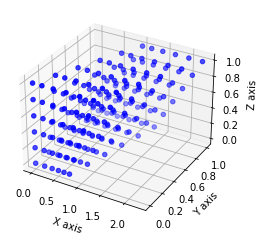

In [21]:
fig = pl.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coor_new[:, 0], coor_new[:, 1], coor_new[:, 2], c='blue', marker='o')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
pl.show()

In [25]:
# Export as the vtk file
from pyevtk.hl import pointsToVTK
# import numpy as np
# Example 1
npoints = 216
pressure = np.random.rand(npoints)
temp = np.linspace(1,npoints,npoints)
pointsToVTK("./rnd_points", np.array(coor_new[:, 0]), np.array(coor_new[:, 1]), np.array(coor_new[:, 2]), data={"temp": temp, "pressure": pressure})

In [26]:
pointsToVTK("./rnd_points2", np.array(coor[:, 0]), np.array(coor[:, 1]), np.array(coor[:, 2]), data={"temp": temp, "pressure": pressure})

'/home/utkarsh/Documents/Python_code/mesh_motion/rnd_points2.vtu'